In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os  # Operating system functionality
import random  # Random number generator
import pandas as pd  # Data analysis & manipulation
import numpy as np  # Array-processing
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Data visualization
from tensorflow.keras import preprocessing, layers, models, callbacks  # Neural networks
from sklearn import metrics  # Model evaluation



print('Libraries imported.')

Libraries imported.


In [4]:
!unzip /content/drive/MyDrive/car_damage/dataset.zip -data

Archive:  /content/drive/MyDrive/car_damage/dataset.zip
   creating: ata/dataset/
   creating: ata/dataset/test/
   creating: ata/dataset/test/damage/
  inflating: ata/dataset/test/damage/damage1.jpg  
  inflating: ata/dataset/test/damage/damage10.jpg  
  inflating: ata/dataset/test/damage/damage100.jpg  
  inflating: ata/dataset/test/damage/damage101.jpg  
  inflating: ata/dataset/test/damage/damage102.jpg  
  inflating: ata/dataset/test/damage/damage103.jpg  
  inflating: ata/dataset/test/damage/damage104.jpg  
  inflating: ata/dataset/test/damage/damage105.jpg  
  inflating: ata/dataset/test/damage/damage106.jpg  
  inflating: ata/dataset/test/damage/damage107.jpg  
  inflating: ata/dataset/test/damage/damage108.jpg  
  inflating: ata/dataset/test/damage/damage109.jpg  
  inflating: ata/dataset/test/damage/damage11.jpg  
  inflating: ata/dataset/test/damage/damage110.jpg  
  inflating: ata/dataset/test/damage/damage111.jpg  
  inflating: ata/dataset/test/damage/damage112.jpg  
  inf

In [7]:
data = '/content/ata/dataset/'
train_path = data + 'train/'
train_good_path = train_path + 'good/'
train_damage_path = train_path + 'damage/'

test_path = data + 'test/'
test_good_path = test_path + 'good/'
test_damage_path = test_path + 'damage/'

# Check the size of each class in both training and testing data
print('Train data, class Good:', len(os.listdir(train_good_path)))
print('Train data, class damage :', len(os.listdir(train_damage_path)))
print('Test data, class Good :', len(os.listdir(test_good_path)))
print('Test data, class damage  :', len(os.listdir(test_damage_path)))

Train data, class Good: 1517
Train data, class damage : 1516
Test data, class Good : 384
Test data, class damage  : 384


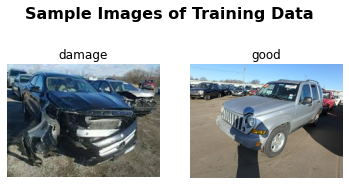

In [10]:
rand_img_def = plt.imread(
    train_damage_path + random.choice(os.listdir(train_damage_path)))
rand_img_ok = plt.imread(
    train_good_path + random.choice(os.listdir(train_good_path)))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(rand_img_def, cmap='gray')
axes[1].imshow(rand_img_ok, cmap='gray')
axes[0].set_title('damage')
axes[1].set_title('good')
axes[0].axis('off')
axes[1].axis('off')
plt.suptitle(
    'Sample Images of Training Data',
    y=0.9, size=16, weight='bold')
plt.show()

In [11]:
img_size, batch_size, seed_num = (300,300), 32, 0

def generate_train_img(train_path, img_size, batch_size, seed_num):
    img_generator = preprocessing.image.ImageDataGenerator(
        rescale=1./255, validation_split=0.2)
    gen_args = dict(
        target_size=img_size,
        color_mode='grayscale',
        classes={'damage':0, 'good':1},
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
        seed=seed_num)
    train_data = img_generator.flow_from_directory(
        directory=train_path, subset='training', **gen_args)
    validation_data = img_generator.flow_from_directory(
        directory=train_path, subset='validation', **gen_args)
    return train_data, validation_data

def generate_test_img(test_path, img_size, batch_size, seed_num):
    img_generator = preprocessing.image.ImageDataGenerator(
        rescale=1./255)
    gen_args = dict(
        target_size=img_size,
        color_mode='grayscale',
        classes={'damage':0, 'good':1},
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
        seed=seed_num)
    test_data = img_generator.flow_from_directory(
        directory=test_path, **gen_args)
    return test_data

# Generate the data
train_data, validation_data = generate_train_img(
    train_path, img_size, batch_size, seed_num)
test_data = generate_test_img(
    test_path, img_size, batch_size, seed_num)

Found 2427 images belonging to 2 classes.
Found 606 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


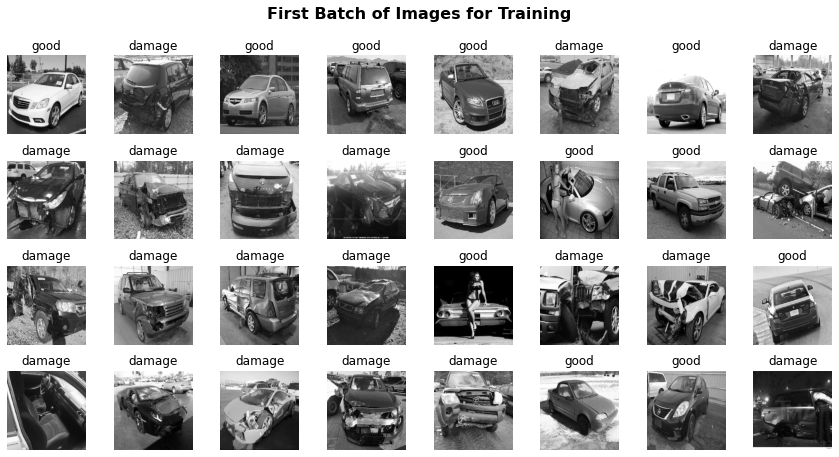

In [12]:
mapping_class = {0: 'damage', 1: 'good'}

def visualize_first_batch(dataset, fig_title):
    images, labels = next(iter(dataset))
    images = images.reshape(batch_size,*img_size)
    fig, axes = plt.subplots(4, 8, figsize=(12,6))
    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(mapping_class[label], size=12)
    plt.tight_layout()
    fig.suptitle(fig_title, y=1.05, size=16, weight='bold')
    plt.show()
    return images

train_batch_1 = visualize_first_batch(
    train_data,
    "First Batch of Images for Training")

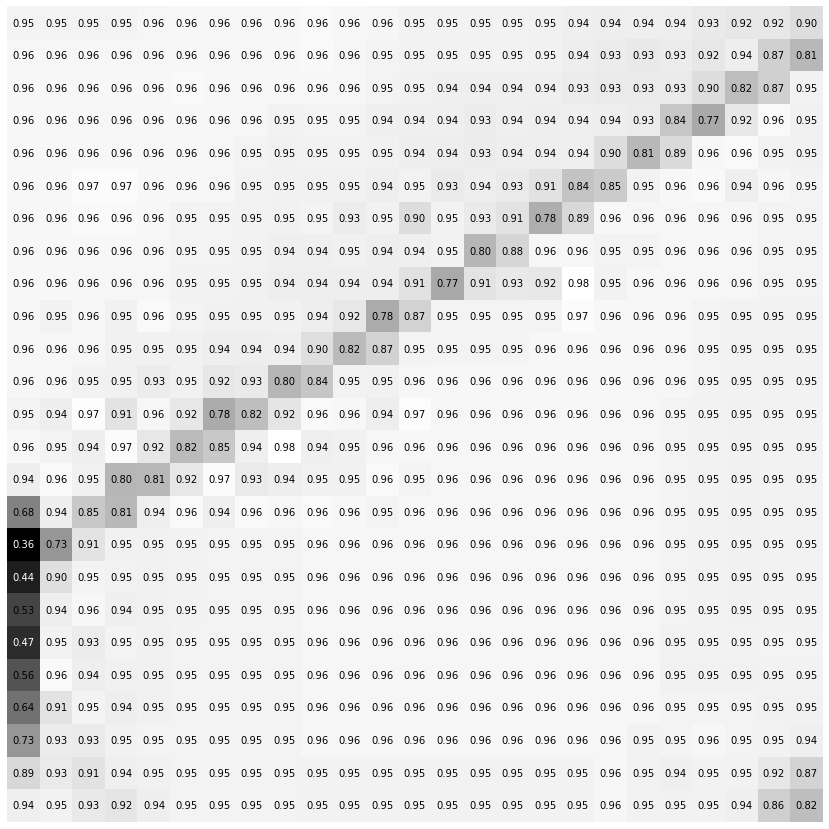

In [13]:
# Make a 25×25 pixels selection from the first image
selected_pxl = np.squeeze(train_batch_1[0])[150:175, 160:185]

def visualize_pixels(selected_pxl):
    fig, ax = plt.subplots(figsize = (15,15))
    ax.imshow(selected_pxl, cmap='gray')
    ax.axis('off')
    pxl_width, pxl_height = selected_pxl.shape
    for x in range(pxl_width):
        for y in range(pxl_height):
            value = selected_pxl[x][y]
            ax.annotate(
                '{:.2f}'.format(value),
                xy=(y,x),
                ha='center',
                va='center',
                color='white' if value<0.5 else 'black')
    
visualize_pixels(selected_pxl)

In [18]:
cnn_model = models.Sequential([
    layers.Conv2D(
        filters=16,
        kernel_size=7,
        strides=2,
        activation='relu',
        padding='same',
        input_shape=img_size+(1,)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(rate=0.2),
    layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(rate=0.2),
    layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(units=1, activation='sigmoid')])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 37, 37, 32)       

In [19]:
stop_early = callbacks.EarlyStopping(
    monitor='val_loss', patience=5)

checkpoint = callbacks.ModelCheckpoint(
    'car_damage_classifier.h5',
    verbose=1,
    save_best_only=True,
    monitor='val_loss')

n_epochs = 15

cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=n_epochs,
    callbacks=[stop_early, checkpoint],
    verbose=1)

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.7182 - accuracy: 0.5027
Epoch 1: val_loss improved from inf to 0.69188, saving model to car_damage_classifier.h5
76/76 [==============================] - 84s 1s/step - loss: 0.7182 - accuracy: 0.5027 - val_loss: 0.6919 - val_accuracy: 0.5050
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5505
Epoch 2: val_loss improved from 0.69188 to 0.66275, saving model to car_damage_classifier.h5
76/76 [==============================] - 84s 1s/step - loss: 0.6873 - accuracy: 0.5505 - val_loss: 0.6627 - val_accuracy: 0.6386
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.6560
Epoch 3: val_loss improved from 0.66275 to 0.63607, saving model to car_damage_classifier.h5
76/76 [==============================] - 83s 1s/step - loss: 0.6195 - accuracy: 0.6560 - val_loss: 0.6361 - val_accuracy: 0.6205
Epoch 4/15
76/76 [==============================] - ETA:

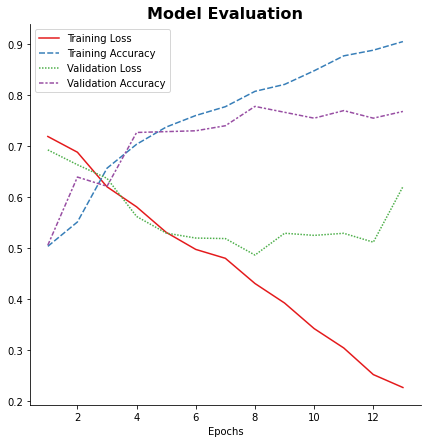

In [20]:
train_result_df = pd.DataFrame(
    cnn_model.history.history,
    index=range(1, 1+len(cnn_model.history.epoch)))

plt.subplots(figsize=(7,7))
sns.lineplot(data=train_result_df, palette='Set1')
plt.xlabel('Epochs')
plt.legend(labels=[
    'Training Loss',
    'Training Accuracy',
    'Validation Loss',
    'Validation Accuracy'])
plt.title('Model Evaluation', size=16, weight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

24/24 [==============================] - 11s 432ms/step


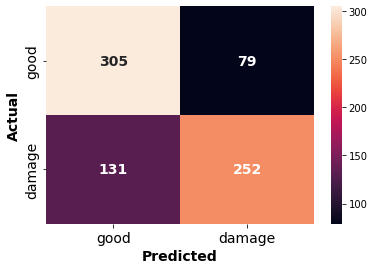

In [21]:
best_model = models.load_model("/content/car_damage_classifier.h5")

# Make predictions on images in the test set
y_pred_proba = best_model.predict(test_data, verbose=1)
threshold = 0.5
y_pred = y_pred_proba >= threshold

# Visualize the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(
    metrics.confusion_matrix(test_data.classes,y_pred),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['good', 'damage'],
    yticklabels=['good', 'damage'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [22]:
print(metrics.classification_report(
    test_data.classes, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.6995    0.7943    0.7439       384
           1     0.7613    0.6580    0.7059       383

    accuracy                         0.7262       767
   macro avg     0.7304    0.7261    0.7249       767
weighted avg     0.7304    0.7262    0.7249       767



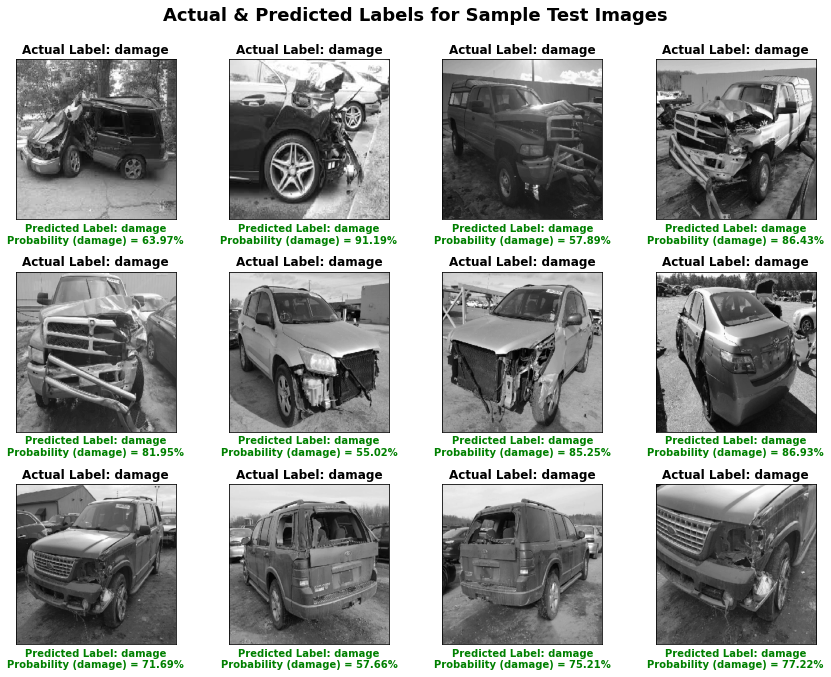

In [23]:
images, labels = next(iter(test_data))
images = images.reshape(batch_size, *img_size)
fig, axes = plt.subplots(3, 4, figsize=(12,9))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    true_label = mapping_class[label]
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = mapping_class[int(pred_prob >= threshold)]
    prob_class = 100*pred_prob if pred_label == 'Defect' else 100*(1-pred_prob)
    ax.set_title(f'Actual Label: {true_label}', weight='bold')
    ax.set_xlabel(
        f'Predicted Label: {pred_label}\nProbability ({pred_label}) = {(prob_class):.2f}%',
        weight='bold', color='green' if true_label == pred_label else 'red')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle('Actual & Predicted Labels for Sample Test Images',
             y=1.04, size=18, weight='bold')
plt.show()

In [28]:
!cp -a /content/car_damage_classifier.h5 /content/drive/MyDrive/car_damage

In [27]:
def real_time(current_frame):
    img = cv2.imread(current_frame)
    grayClone = cv2.cvtColor(np.float32(img),cv2.COLOR_BGR2GRAY)
    #print(img.shape)
    img = cv2.resize(grayClone, (300, 300))
    
    img = img/255 #rescalinng
    pred_img =img.copy()
    prob = best_model.predict(img.reshape(-1,300,300,1))
    print(prob[0])
    # prob=np.argmax(prob,axis=1)
    # print(prob)
    if (prob>0.5):
        return "All good"
    else:
        return "damage"

from google.colab import files
import cv2
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
print()
print()
print("-------------------------------------------------")
print(real_time(fn))

Saving damage1004.jpg to damage1004.jpg
User uploaded file "damage1004.jpg" with length 11344 bytes


-------------------------------------------------
[0.20107207]
damage
